In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d


### create spikes df

In [2]:
# pull in QC
df_preproc = pd.read_csv('../../results/202512/preproc.csv')[['channel', 'unit', 'keep']]
df_preproc['keep'] = df_preproc['keep'].fillna(0)
df_preproc

,channel,unit,keep
0,1.0,596.0,0.0
1,1.0,612.0,0.0
2,2.0,1432.0,0.0
3,2.0,1502.0,0.0
4,2.0,1543.0,0.0
...,...,...,...
86,31.0,182.0,0.0
87,31.0,188.0,0.0
88,32.0,167.0,0.0
89,32.0,174.0,0.0


In [3]:
# get [clustIDs] where df[keep] = 0
dropped_clustIDs = df_preproc[df_preproc['keep'] != 1]['unit'].tolist()
dropped_clustIDs.extend([0, 99999999])
print(dropped_clustIDs)

[596.0, 612.0, 1432.0, 1502.0, 1543.0, 506.0, 703.0, 636.0, 683.0, 1469.0, 2405.0, 2423.0, 2457.0, 2481.0, 1518.0, 1755.0, 1348.0, 1396.0, 1553.0, 1566.0, 1715.0, 1772.0, 976.0, 1042.0, 1045.0, 1433.0, 1799.0, 1825.0, 1953.0, 1712.0, 2185.0, 2769.0, 3203.0, 3227.0, 2308.0, 2323.0, 264.0, 571.0, 1998.0, 1747.0, 1901.0, 1921.0, 1585.0, 1736.0, 1558.0, 2261.0, 2280.0, 1663.0, 1678.0, 1373.0, 1882.0, 130.0, 147.0, 82.0, 117.0, 141.0, 163.0, 157.0, 172.0, 148.0, 151.0, 118.0, 156.0, 182.0, 188.0, 167.0, 174.0, nan, 0, 99999999]


In [4]:
def get_ID_spikes_dict(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    ID_spikes_dict = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in ID_spikes_dict: ID_spikes_dict[clustID] = [] # init

        ID_spikes_dict[clustID].append(spike)

    return ID_spikes_dict

In [5]:
samp_rate = 1000000
neur_spikes_df = []

data_dir = '../../results/202512/osort_mat/sort/5'
for channel_num in range(len(os.listdir(data_dir))):

    channel_mat = sio.loadmat(f'{data_dir}/A{channel_num+1}_sorted_new.mat')

    # get (1 * n_spikes) clusterID & spiketimes
    clust_IDs = channel_mat['assignedNegative'][0]
    spikes = channel_mat['newTimestampsNegative'][0]

    # get clusterID: [spikes]
    ID_spikes_dict = get_ID_spikes_dict(clust_IDs, spikes)

    # 1 row per clustID
    clust_df = pd.DataFrame([
        {
            "channel": channel_num + 1,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in ID_spikes_dict.items()
    ])
    neur_spikes_df.append(clust_df)

    # if channel_num > 10: break

neur_spikes_df = pd.concat(neur_spikes_df, ignore_index=True)


In [6]:
n_neurs = len(neur_spikes_df)
print(f'#neurs: {n_neurs}')
eg_spikes = neur_spikes_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
neur_spikes_df

#neurs: 23
last 5 spikes (s): [1620.1233     1620.19223333 1620.53116667 1620.94453333 1621.08233333]
last 5 spikes (min): [27.002055   27.00320389 27.00885278 27.01574222 27.01803889]


,channel,clustID,spikes,#spikes,avgFR
0,2,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888
1,5,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957
2,6,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268
3,6,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394
4,6,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609
5,7,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596
6,8,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269
7,8,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847
8,9,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766
9,9,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493


### psychopy

In [7]:
df_subjs = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
subj_df = df_subjs[df_subjs['subj'] == '12'].copy()
subj_df

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,signed_err,unsigned_err,...,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122,invalid,missed,purely_incorrect,stim_ranks,resp_ranks
0,0.0,0.0,-0.400,0.0,-0.38,0.0,0.0,0.0,-0.020,0.020,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,1.5
1,1.0,0.0,-0.148,-0.0,-0.38,0.0,0.0,0.0,0.232,0.232,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,20.0
2,0.0,0.0,-0.308,0.0,-0.34,0.0,0.0,0.0,0.032,0.032,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,7.0
3,1.0,0.0,-0.304,-0.0,-0.34,0.0,0.0,0.0,0.036,0.036,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,8.0
4,0.0,0.0,-0.328,0.0,-0.30,0.0,0.0,0.0,-0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,False,False,False,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.0,0.0,0.224,0.2,0.34,1.0,1.0,0.0,-0.116,0.116,...,NaN,NaN,NaN,NaN,NaN,False,False,False,34.5,20.0
236,0.0,0.0,0.292,0.2,0.38,1.0,1.0,0.0,-0.088,0.088,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,32.0
237,1.0,0.0,0.252,0.2,0.38,1.0,1.0,0.0,-0.128,0.128,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,23.5
238,0.0,0.0,0.384,0.2,0.38,1.0,1.0,0.0,0.004,0.004,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,38.0


In [8]:
phases = ['baseline', 'stim', 'delay', 'task', 'anticipation', 'feedback']
phase_bounds_dict = {}

for phase in phases:

    # e.g., baseline: ['baseline.started', 'baseline.stopped']
    phase_bounds_dict[phase] = [f'{phase}.started', f'{phase}.stopped']

    # # optional. sid, check
    # if phase == 'stim': phase_bounds_dict[phase] = [f'target_stim.started', f'{phase}.stopped']
    # if phase == 'feedback': phase_bounds_dict[phase] = [f'no_resp_text.started', f'{phase}.stopped']

phase_cols = []
for key, val in phase_bounds_dict.items():
    phase_cols.extend(val)
    print(f'{key}: {val}')

subj_df[phase_cols]

baseline: ['baseline.started', 'baseline.stopped']
stim: ['stim.started', 'stim.stopped']
delay: ['delay.started', 'delay.stopped']
task: ['task.started', 'task.stopped']
anticipation: ['anticipation.started', 'anticipation.stopped']
feedback: ['feedback.started', 'feedback.stopped']


,baseline.started,baseline.stopped,stim.started,stim.stopped,delay.started,delay.stopped,task.started,task.stopped,anticipation.started,anticipation.stopped,feedback.started,feedback.stopped
0,179.287941,180.223108,180.223534,181.220776,181.221150,182.505846,182.507335,183.771864,183.772263,184.020854,184.021192,185.020908
1,223.455750,224.339824,224.340248,225.338597,225.338994,226.824359,226.825565,228.122857,228.123211,228.372063,228.372396,229.372133
2,84.668625,85.654174,85.654526,86.651546,86.651923,88.135832,88.137054,89.735787,89.736143,89.984966,89.985295,90.985009
3,129.803268,130.788351,130.789024,131.786087,131.786473,133.121612,133.123205,134.437185,134.437590,134.686145,134.686486,135.686205
4,72.568310,73.453843,73.454512,74.451224,74.451600,75.936204,75.937423,77.035449,77.035813,77.284656,77.285009,78.284667
...,...,...,...,...,...,...,...,...,...,...,...,...
235,1523.824445,1524.759799,1524.760366,1525.757295,1525.757669,1527.092060,1527.093282,1528.724787,1528.725147,1528.974048,1528.974373,1529.974116
236,1418.888245,1419.773327,1419.773661,1420.771101,1420.771475,1422.105695,1422.107137,1423.738572,1423.738923,1423.987802,1423.988133,1424.987862
237,1559.742073,1560.727593,1560.728215,1561.724937,1561.725308,1563.010160,1563.011427,1564.192590,1564.192956,1564.441677,1564.442014,1565.441714
238,1407.721291,1408.655590,1408.655942,1409.654137,1409.654537,1410.939023,1410.940716,1411.888314,1411.888668,1412.137453,1412.137788,1413.137560


### get FRs

In [9]:
def get_phase_spikes_and_FRs(subj_df, neur_spikes_df, phase, prestart, stop, size, dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in phase window '''
    
    if phase == 'baseline': prestart = .3 # to prevent spillover from feedback

    # bin edges & centers for hists & plots
    bin_edges = np.arange(prestart, stop + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & stop edges
    n_bins = len(bin_edges) - 1

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.zeros((len(subj_df), len(neur_spikes_df)), dtype=object)
    trial_neur_FRs = np.zeros((len(subj_df), len(neur_spikes_df), n_bins))

    for trial_i, trial_row in subj_df.iterrows():

        trial_phase_onset = trial_row[f'{phase}.started']

        for neur_i, neur_row in neur_spikes_df.iterrows():

            spike_train = np.zeros(n_bins)

            # phase spike times, aligned
            trial_phase_spikes = neur_row['spikes'][(neur_row['spikes'] >= trial_phase_onset + prestart) &
                                                    (neur_row['spikes'] <= trial_phase_onset + stop)]
            trial_phase_spikes = trial_phase_spikes - trial_phase_onset
            trial_neur_spikes[trial_i, neur_i] = trial_phase_spikes

            # histogram counts → Hz
            counts, _ = np.histogram(trial_phase_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt

            # for this trial and neuron, store smoothed FRs across bins
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)
            trial_neur_FRs[trial_i, neur_i, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

# bin params
prestart, stop, size, dt = -.5, 1, .05, .001
# for norming by baseline
base_spikes, base_FRs, bin_centers = get_phase_spikes_and_FRs(subj_df, neur_spikes_df, 'baseline', prestart, stop, size, dt)

### create conditions

In [10]:
# OUTCOME
outcome_spikes, outcome_FRs, bin_centers = get_phase_spikes_and_FRs(subj_df, neur_spikes_df, 'feedback', prestart=prestart, stop=stop, size=size, dt=dt)
outcome_FRs_normed = outcome_FRs / base_FRs.mean(axis=(0, 2), keepdims=True)
# conditions
out3_ids = subj_df[subj_df['outcome'] == 3].index
out1_ids = subj_df[subj_df['outcome'] == 1].index
print('OUTCOME')
print('spike_times (#trials, #neurs)')
print(f'outcome=3: {outcome_spikes[out3_ids, :].shape}')
print(f'outcome=1: {outcome_spikes[out1_ids, :].shape}')
print()
print('FRs (#trials, #neurs, #bins)')
print(f'outcome=3: {outcome_FRs_normed[out3_ids, :, :].shape}')
print(f'outcome=1: {outcome_FRs_normed[out1_ids, :, :].shape}')
print()

# STIMVAL
stimVal_spikes, stimVal_FRs, bin_centers = get_phase_spikes_and_FRs(subj_df, neur_spikes_df, 'stim', prestart=prestart, stop=stop, size=size, dt=dt)
stimVal_FRs_normed = stimVal_FRs / base_FRs.mean(axis=(0, 2), keepdims=True)
# conditions
stimPos_ids = subj_df[subj_df['stim_pos_aligned'] > 0].index
stimNeg_ids = subj_df[subj_df['stim_pos_aligned'] < 0].index
print('STIMVAL')
print('spike_times (#trials, #neurs)')
print(f'stimPos: {stimVal_spikes[stimPos_ids, :].shape}')
print(f'stimNeg: {stimVal_spikes[stimNeg_ids, :].shape}')
print()
print('FRs (#trials, #neurs, #bins)')
print(f'stimPos: {stimVal_FRs_normed[stimPos_ids, :, :].shape}')
print(f'stimNeg: {stimVal_FRs_normed[stimNeg_ids, :, :].shape}')
print()

OUTCOME
spike_times (#trials, #neurs)
outcome=3: (113, 23)
outcome=1: (111, 23)

FRs (#trials, #neurs, #bins)
outcome=3: (113, 23, 1500)
outcome=1: (111, 23, 1500)

STIMVAL
spike_times (#trials, #neurs)
stimPos: (120, 23)
stimNeg: (120, 23)

FRs (#trials, #neurs, #bins)
stimPos: (120, 23, 1500)
stimNeg: (120, 23, 1500)



### plot

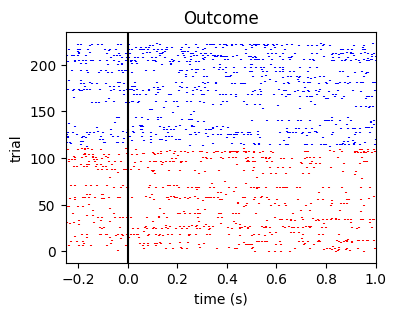

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


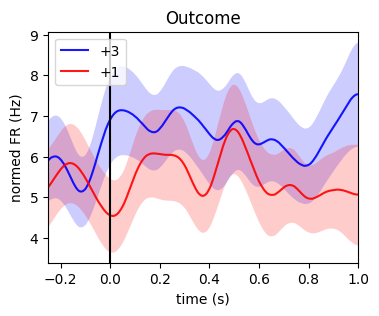

In [33]:
outcome_neur_id = 3

# raster
plt.figure(figsize=(4,3))
plt.title('Outcome')
raster_list = list(outcome_spikes[out1_ids, outcome_neur_id]) + list(outcome_spikes[out3_ids, outcome_neur_id])
color_list = ['red'] * len(out1_ids) + ['blue'] * len(out3_ids)
plt.eventplot(raster_list, orientation='horizontal', colors=color_list)
plt.axvline(0, color='black', linestyle='-')
plt.ylabel('trial')
plt.xlabel('time (s)')
plt.xlim([-.25, 1])
plt.savefig(f'../../data/eps_figs/eg_outcome_neur_raster.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

# psth
plt.figure(figsize=(4,3))
plt.title('Outcome')

for outcome, outcome_ids, color in zip(['+3', '+1'], [out3_ids, out1_ids], ['b', 'r']):
    data = outcome_FRs[outcome_ids, outcome_neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    plt.plot(bin_centers, mu, color=color, alpha=0.9, label=outcome)
    plt.fill_between(bin_centers, mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)
    
plt.axvline(0, color='black', linestyle='-')
plt.ylabel('normed FR (Hz)')
plt.xlabel('time (s)')
plt.xlim([-.25, 1])
plt.legend(loc='upper left')
plt.savefig(f'../../data/eps_figs/eg_outcome_neur_PSTH.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


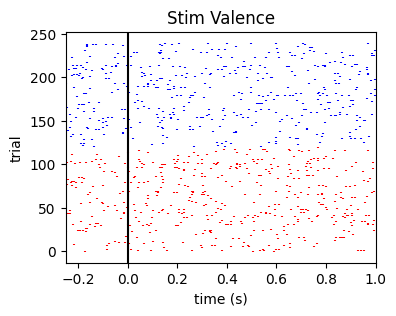

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


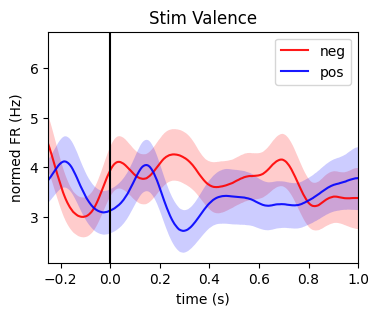

In [34]:
stimVal_neur_id = 2

# raster
plt.figure(figsize=(4,3))
plt.title('Stim Valence')
raster_list = list(stimVal_spikes[stimNeg_ids, stimVal_neur_id]) + list(stimVal_spikes[stimPos_ids, stimVal_neur_id])
color_list = ['red'] * len(stimNeg_ids) + ['blue'] * len(stimPos_ids)
plt.eventplot(raster_list, orientation='horizontal', colors=color_list)
plt.axvline(0, color='black', linestyle='-')
plt.ylabel('trial')
plt.xlabel('time (s)')
plt.xlim([-.25, 1])
plt.savefig(f'../../data/eps_figs/eg_stimVal_neur_raster.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

# psth
plt.figure(figsize=(4,3))
plt.title('Stim Valence')

for stim_val, stim_ids, color in zip(['neg', 'pos'], [stimNeg_ids, stimPos_ids], ['r', 'b']):
    data = stimVal_FRs[stim_ids, stimVal_neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    plt.plot(bin_centers, mu, color=color, alpha=0.9, label=stim_val)
    plt.fill_between(bin_centers, mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

plt.axvline(0, color='black', linestyle='-')
plt.ylabel('normed FR (Hz)')
plt.xlabel('time (s)')
plt.xlim([-.25, 1])
plt.legend()
plt.savefig(f'../../data/eps_figs/eg_stimVal_neur_PSTH.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

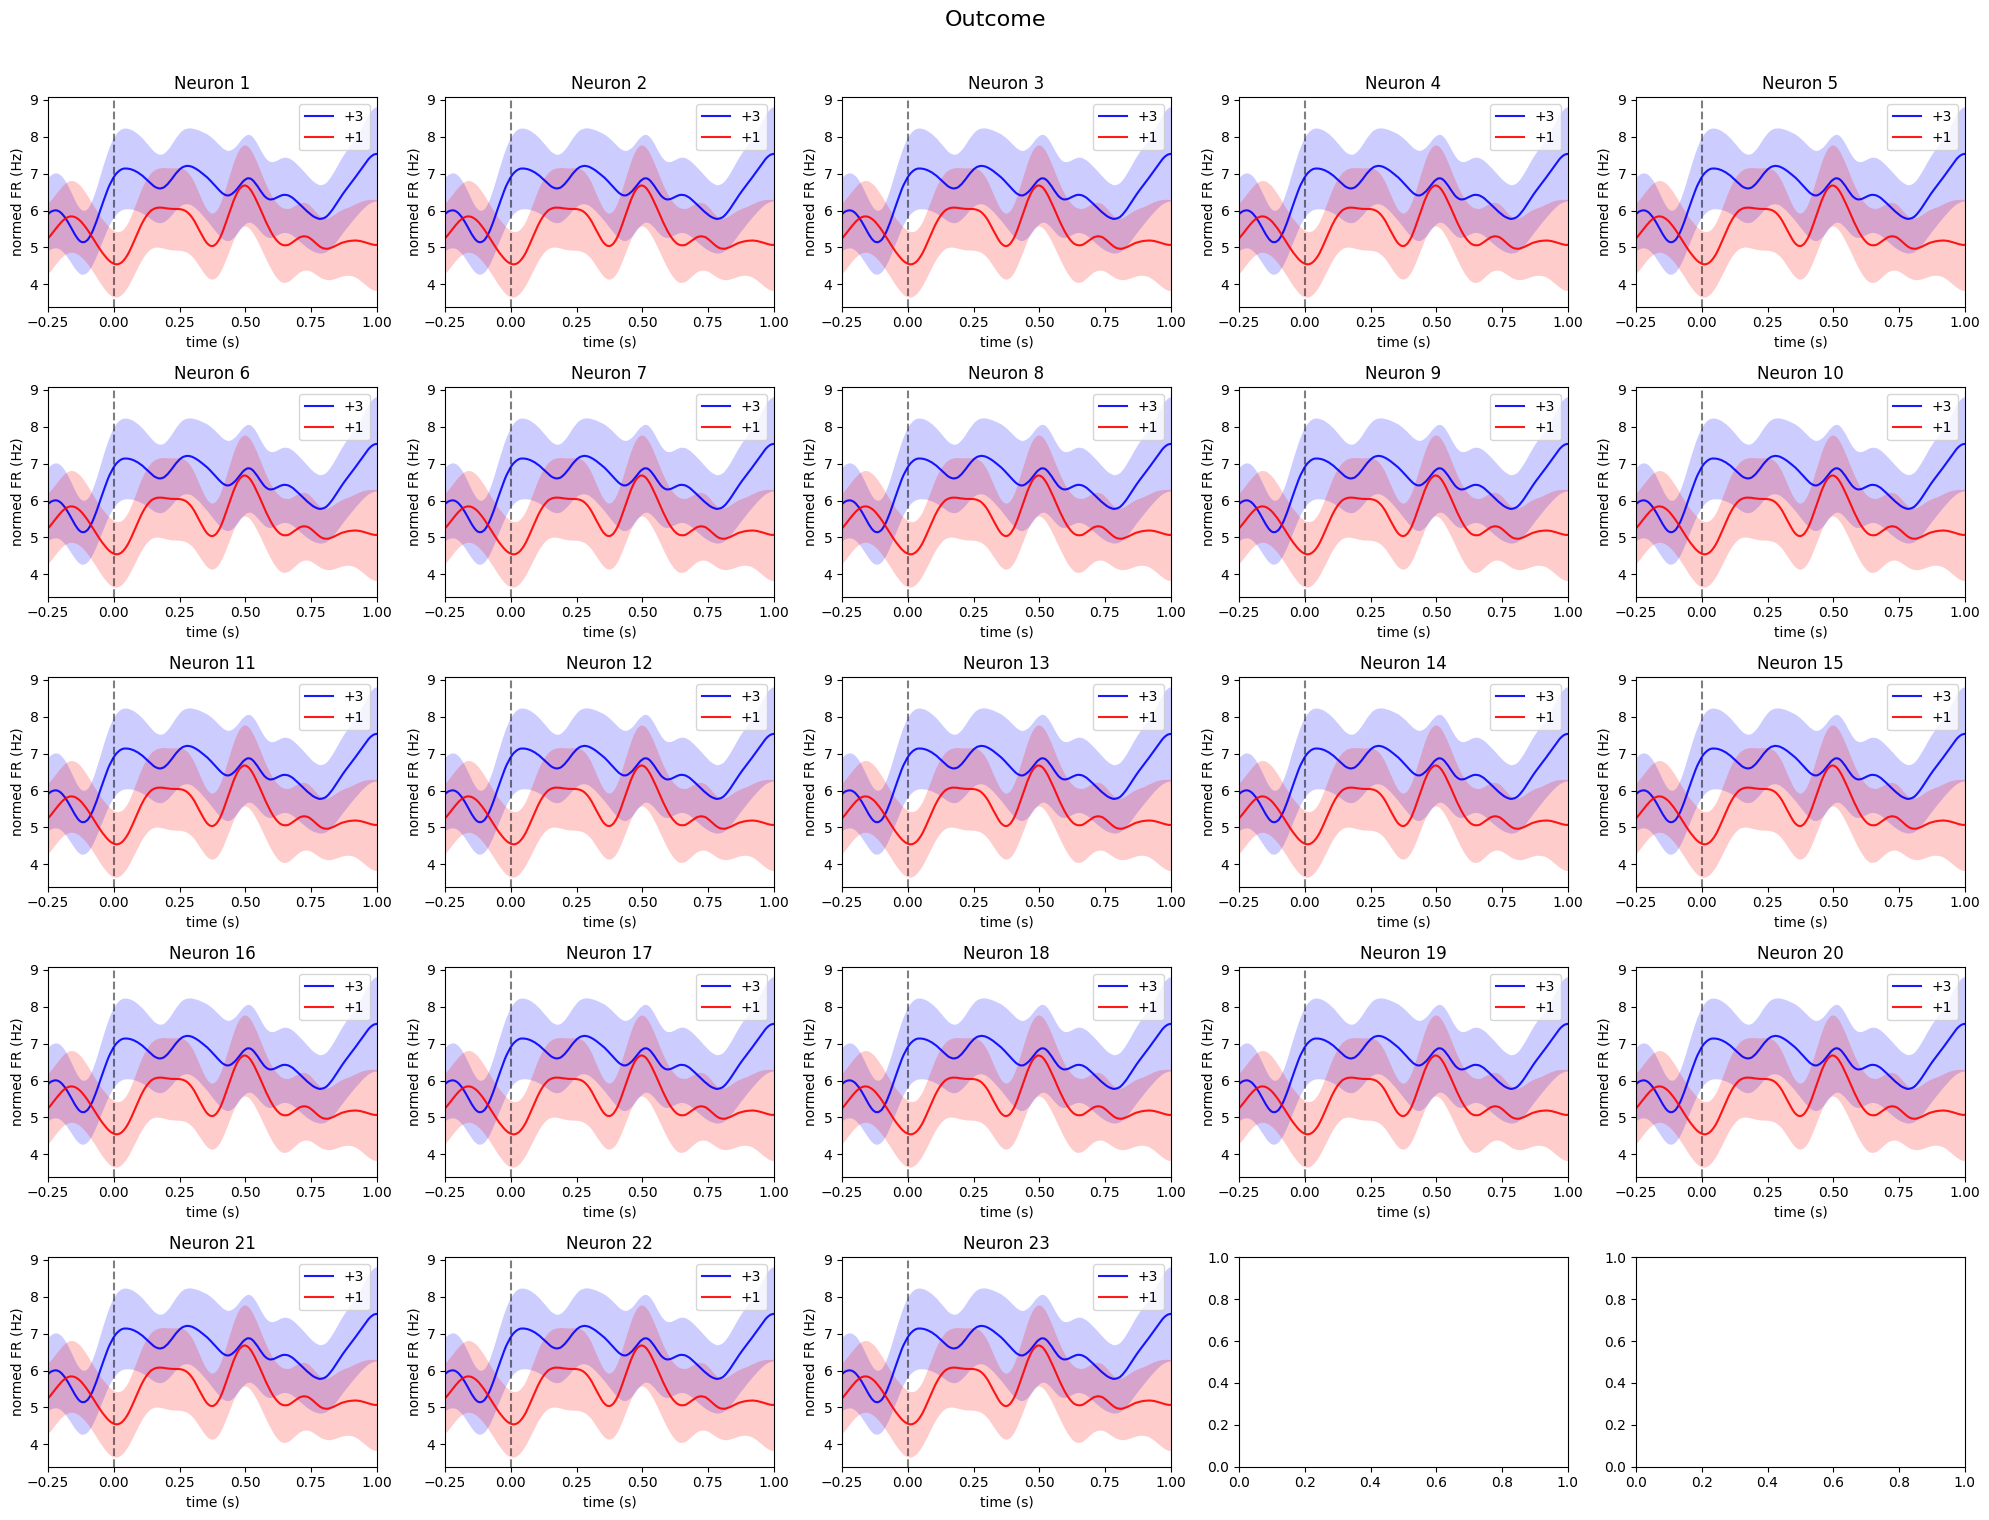

In [ ]:
n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):

    for outcome, outcome_ids, color in zip(['+3', '+1'], [out3_ids, out1_ids], ['b', 'r']):
        data = outcome_FRs[outcome_ids, outcome_neur_id, :]
        mu = data.mean(axis=0)
        sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
        axs[ax].plot(bin_centers, mu, color=color, alpha=0.9, label=outcome)
        axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

    axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'Neuron {neur_i+1}', ylabel='normed FR (Hz)', xlabel='time (s)', xticks=np.linspace(-.25, 1, 6), xlim=[-.25, 1])
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle('Outcome', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


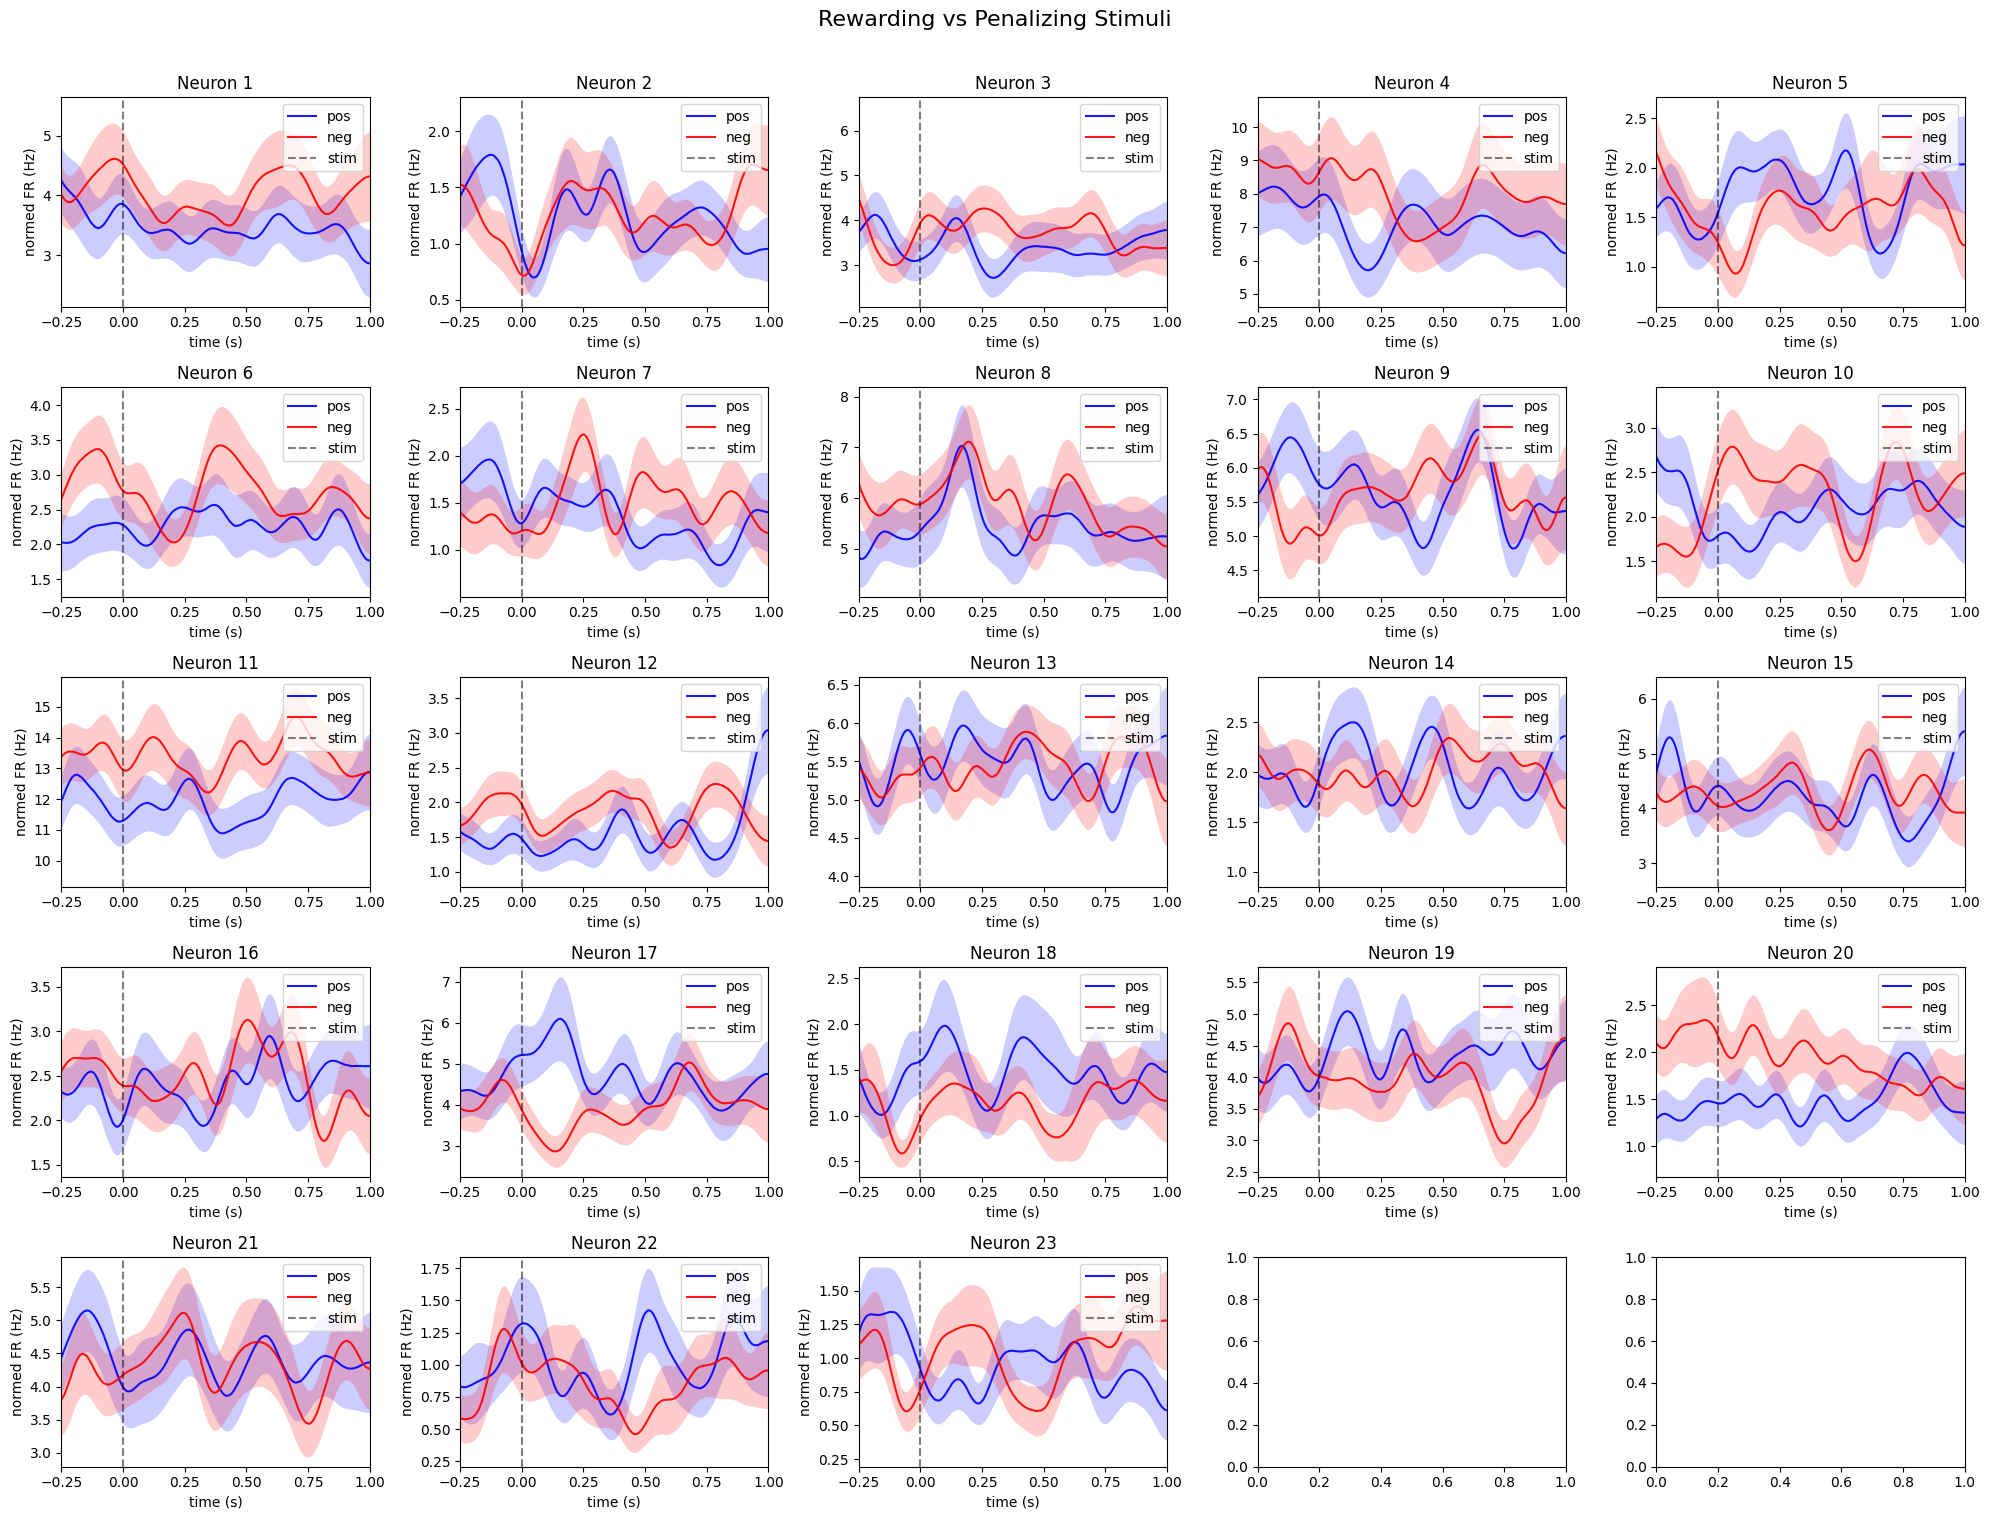

In [ ]:
n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):

    for stimVal, stimVal_ids, color in zip(['pos', 'neg'], [stimPos_ids, stimNeg_ids], ['b', 'r']):
        data = stimVal_FRs[stimVal_ids, neur_i, :]
        mu = data.mean(axis=0)
        sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
        axs[ax].plot(bin_centers, mu, color=color, alpha=0.9, label=stimVal)
        axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

    axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5, label='stim')
    axs[ax].set(title=f'Neuron {neur_i+1}', ylabel='normed FR (Hz)', xlabel='time (s)', xticks=np.linspace(-.25, 1, 6), xlim=[-.25, 1])
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle('Rewarding vs Penalizing Stimuli', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


### duration checks for stim & feedback

In [15]:
# n_rows, n_cols = 1, 2
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# print(len(subj_df['no_resp_text.started']))
# axs[ax].hist(subj_df['no_resp_text.started']-subj_df['feedback.started'], bins=30)
# axs[ax].set_title('no_resp_text.started - feedback.started (s)')
# ax += 1

# axs[ax].hist(subj_df['target_stim.started']-subj_df['stim.started'], bins=30)
# axs[ax].set_title('target_stim.started - stim.started (s)')

# plt.suptitle('duration checks')
# plt.tight_layout()
# plt.show()